# 0.0. IMPORTS

In [131]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from IPython.core.display import HTML
import matplotlib.pyplot as plt

## 0.1. HELPER FUNCTIONS

In [132]:
# Configura os gráficos
# def jupyter_settings():
%matplotlib inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24

display(HTML('<style>.conteiner{width:100% !important;}</style>'))

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.expand_frame_repr', False)
# configura o pandas para quantidade de casas decimeis
pd.set_option('display.float_format', lambda x: '%.2f' % x)

sns.set()

## 0.2. LOADING DATA

In [133]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

# 1.0. DESCRIÇÃO DOS DADOS

In [134]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [135]:
# colunas originais do dataset pego com ctrl-c no columns
col_old = ["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo", "StateHoliday",
            "SchoolHoliday", "StoreType", "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth",
            "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval",]

#snake_case = lambda x: inflection.underscore(x)
# Usando a função underscore da biblioteca inflection para substituir camelCase por snake_case
col_new = list(map(lambda x: inflection.underscore(x), col_old))

df1.columns = col_new

## 1.2. Data Dimensions

In [136]:
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 1017209
Number of columns: 18


## 1.3. Data Types

In [137]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [138]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FILLOUT NA

In [139]:
# Preenchendo valores falntantes de competition_distance
df1["competition_distance"] = df1["competition_distance"].apply(
    lambda x: 200000 if math.isnan(x) else x
)

# Preenchendo valores falntantes de competition_open_since_month
df1["competition_open_since_month"] = df1.apply(
    lambda x: x["date"].month
    if math.isnan(x["competition_open_since_month"])
    else x["competition_open_since_month"],
    axis=1,
)

# Preenchendo valores falntantes de competition_open_since_year
df1["competition_open_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["competition_open_since_year"])
    else x["competition_open_since_year"],
    axis=1,
)

# Preenchendo valores falntantes de promo2_since_week
df1["promo2_since_week"] = df1.apply(
    lambda x: x["date"].week
    if math.isnan(x["promo2_since_week"])
    else x["promo2_since_week"],
    axis=1,
)

# Preenchendo valores falntantes de promo2_since_year
df1["promo2_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["promo2_since_year"])
    else x["promo2_since_year"],
    axis=1,
)

# Preenchendo valores falntantes de promo_interval
# Criando um dicionário para auxiliar
# Na aula foi usado Fevereiro == Fev e Setembro == Sep mas
# no dataset está Fevereiro == Feb e Setembro == Sept
month_map = {
    1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec",
}
# Completa com zeros os valores faltantes
df1['promo_interval'].fillna(0, inplace=True)
# Coluna que recebe o mês (num) de df['date'] convertido para a sigla
df1['month_map'] = df1['date'].dt.month.map(month_map)
# Recebe 1 caso o mês de month_map esteja em promo_interval caso contrário 0
df1['is_promo'] = df1.apply(
    lambda x: 0 if x['promo_interval'] == 0 
    else 1 if x['month_map'] in x['promo_interval'].split(',') 
    else 0, 
    axis=1)

## 1.6. Change Types

In [140]:
# Alterando os tipos de dados
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [141]:
# Separando os atributos entre numéricos e categóricos
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [142]:
# Central tendency - mean, median
media = pd.DataFrame(numerical_attributes.apply(np.mean)).T
mediana = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
dev_pad = pd.DataFrame(numerical_attributes.apply(np.std)).T
minimo = pd.DataFrame(numerical_attributes.apply(min)).T
maximo = pd.DataFrame(numerical_attributes.apply(max)).T
rang = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([minimo, maximo, rang, media, mediana, dev_pad, skew, kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'minimo', 'maximo', 'rang', 'media', 'mediana', 'dev_pad', 'skew', 'kurtosis']

In [143]:
metrics

,attributes,minimo,maximo,rang,media,mediana,dev_pad,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


c:\Users\Baby\Documents\Python\repos\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

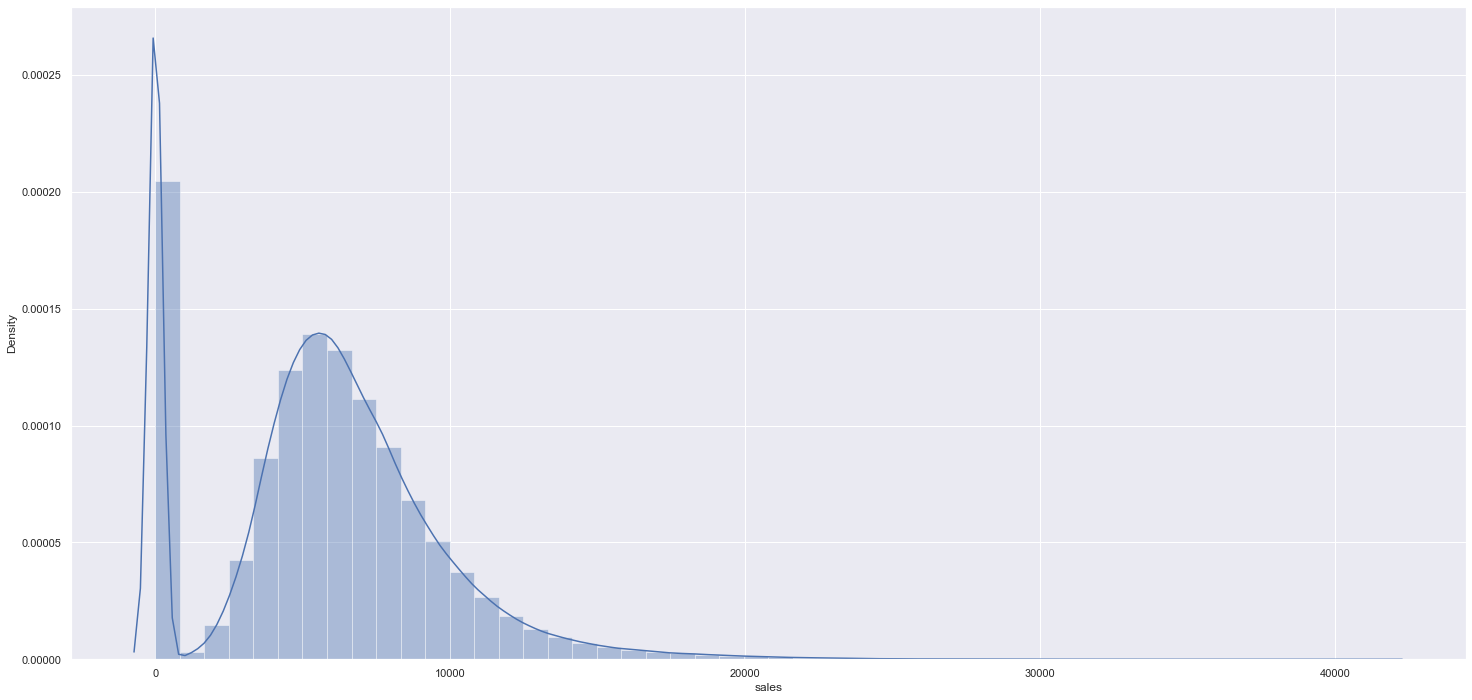

In [144]:
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [145]:
categorical_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

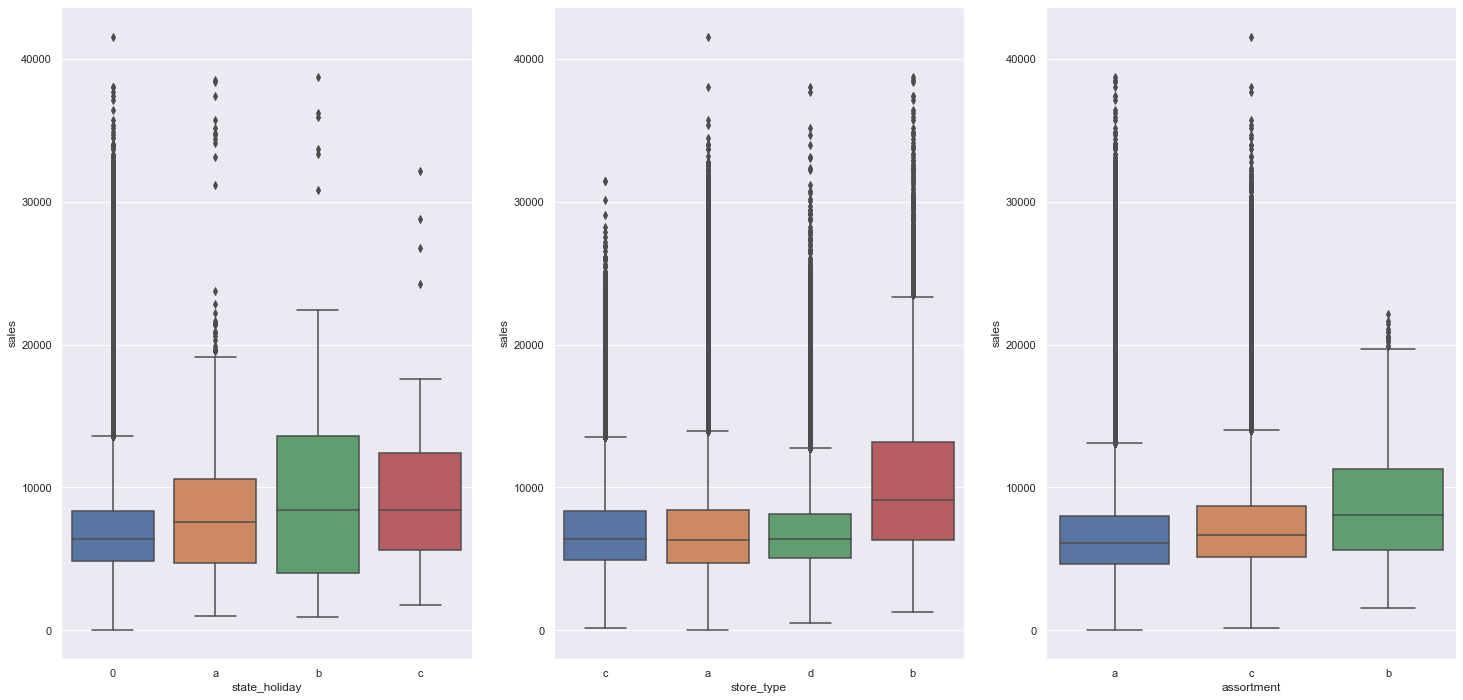

In [148]:
aux = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
# sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

In [153]:
df1['state_holiday'].value_counts()


0    986159
a     20260
b      6690
c      4100
Name: state_holiday, dtype: int64